<a href="https://colab.research.google.com/github/Athreya99/Analytics/blob/main/HotelSearchEngine_with_FAISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#  Hotel listings clustering and search
# Dataset: https://www.kaggle.com/datasets/hamzafarooq50/hotel-listings-and-reviews
# Country: Bali

!pip install -q faiss-cpu
!pip install -q sentence_transformers
!pip install -q nltk
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
!kaggle datasets download -d hamzafarooq50/hotel-listings-and-reviews
!mkdir train
!unzip -q hotel-listings-and-reviews.zip -d train

Saving kaggle.json to kaggle (3).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
hotel-listings-and-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘train’: File exists
replace train/HotelListInAthens__en2019100120191005.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#Prepping Dataset for LDA Topic Modeling and FAISS Querying

##Importing Libraries for Data Cleaning, Preprocessing, LDA, and FAISS

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from pprint import pprint
import numpy as np
np.random.seed(1337)
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')
import requests
import os
from sentence_transformers import SentenceTransformer
import faiss
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import preprocessing

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##Ingest Dataset from Imported Kaggle CSV's

*   Created a Pandas Dataframe by reading hotelReviewsInBali.csv file
*   We dropped the columns 'hotelUrl' and 'review_date' from the dataframe
*   We dropped the duplicate rows if any, and  kept the first instance of the duplicate row
*   Dropped missing values in the dataframe

In [ ]:
bali_hotel_list = 'train/HotelListInBali__en2019100120191005.csv'
bali_hotel_review = 'train/hotelReviewsInBali__en2019100120191005.csv'
df_raw = pd.read_csv(bali_hotel_review, on_bad_lines='skip')
df_raw = df_raw.rename(columns={'Unnamed: 0': 'index'})
print(df_raw.columns)
df_raw = df_raw.drop(['hotelUrl', 'review_date'], axis=1)
print(df_raw.shape)
# keep first duplicate row and drop the other duplicates
df_raw = df_raw.drop_duplicates()
print(df_raw.shape)
# drop missing values
df_raw = df_raw.dropna()
print(df_raw.shape)

documents = df_raw.copy(deep=True)
documents = documents.drop(['hotelName'], axis=1)
cols = documents.columns.tolist()[-1:] + documents.columns.tolist()[:-1]
documents = documents[cols] #reorder the columns
print(documents.sample(n=10, replace=False, random_state=1)) #print random sample of 10 rows

Index(['index', 'review_body', 'review_date', 'hotelName', 'hotelUrl'], dtype='object')
(1684, 3)
(1684, 3)
(1684, 3)
                                            review_body  index
943   We had a lovely beach view room, very spacious...    943
1575  We came to Hideaway Villas to recharge.The GM ...   1575
1314  If you want a place to relax this it ! It’s wo...   1314
577   A beautiful place and very friendly service. L...    577
1219  This establishment deserves 10 stars! From the...   1219
976   A lovely property with some superb bungalows a...    976
729   THE BEST HOTEL EVER. beautiful design. Super f...    729
572   I loved my stay at the Sankara. I had a privat...    572
1257  We recently stayed 6 nights at the Holiday Inn...   1257
995   Our first stay here at Pinkcoco and we just lo...    995


##Define LDA preprocessing functions

Here we are trying to to reduce the number of unique words in a text document and group together words with similar meanings, which can make it easier to analyze the text.

preprocess(text):

*   gensim's simple_preprocess() : tokenizes the text, which means it breaks the text into individual words or tokens.
*   Next, it checks if each token is not a stopword (common words like "the" or "and" that doesn't carry much meaning), and is longer than three characters.
*   If the token passes these checks, it applies the lemmatize_stemming()

lemmatize_stemming(text):
*   WordNetLemmatizer : this reduces each word to its base form i.e dogs to dog.
*   SnowballStemmer   : this further reduces each word to its root form i.e running to run


In [ ]:
def lemmatize_stemming(text):
    return SnowballStemmer(language='english').stem(WordNetLemmatizer().lemmatize(text, pos='v')) #this lemmatizes the input word using the WordNetLemmatizer, then applies stemming using the SnowballStemmer
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text): #iiterates over each token in the preprocessed text
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3: #checks if the token is not a stopword
            result.append(lemmatize_stemming(token)) #lemmatize and add it to the result list
    return result

##Create the Processed Reviews and Corpuses

*  Here we are processing the text reviews in the 'review_body' column of the documents dataframe using the preprocess function defined earlier.
*   Using corpora.Dictionary() method we are mapping each token to a unique integer ID.


*   doc2bow() method is used to create a bag-of-words (BoW). The BoW representation is a list of (token_id, token_count) where token_count is the number of times the token appears in the document.
*   models.TfidfModel() is used to weight the importance of each token in a document based on its frequency in the document and its frequency in the entire corpus.
*   TF-IDF stands for Term Frequency-Inverse Document Frequency.

In [ ]:
processed_docs = documents['review_body'].map(preprocess) #applies preprocess function to each document in the 'review_body' column
dictionary = gensim.corpora.Dictionary(processed_docs) #map each unique token in the documents to a unique integer ID.
dictionary.filter_extremes(no_below=5, no_above=0.8, keep_n=100000) #remove token that appear in fewer than 5 documents or more than 80% of documents
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs] #creates a bag of words and maps eavh to token to integer ID and count the freq of tokens
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus] #applies the TF-IDF weighting to the bag-of-words corpus

#Run TFIDF LDA Topic modeling with 4 topics

*   Here we are training an LDA (Latent Dirichlet Allocation) model on a corpus of documents represented as a TF-IDF (Term Frequency-Inverse Document Frequency) matrix.
*  Here we are creating a model with 4 topics, and then printing out the top words for each topic along with the weight of each word in that topic.
*  The weight represents the importance of that word in that topic, and is calculated based on how frequently that word occurs in documents that are assigned to that topic.




In [ ]:
num_topics = 4  #sets the number of topics that the LDA model should identify in the corpus.
alpha = 1/num_topics #sets the hyperparameter alpha for the LDA model(controls the sparsity of the topic distribution for each document)
eta = 'auto' #sets the hyperparameter eta for the LDA model (controls the sparsity of the word distribution for each topic)
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=2, workers=4, alpha=alpha, eta=eta) #create instance of LDA model
for idx, topic in lda_model_tfidf.print_topics(-1): #loops over each topic identified by the LDA model and prints the top words in that topic.
    print('Topic: {}: {}'.format(idx, topic))

Topic: 0: 0.006*"hotel" + 0.005*"love" + 0.005*"beauti" + 0.005*"resort" + 0.005*"view" + 0.005*"great" + 0.004*"stay" + 0.004*"room" + 0.004*"night" + 0.004*"villa"
Topic: 1: 0.006*"good" + 0.005*"hotel" + 0.005*"villa" + 0.005*"room" + 0.005*"nice" + 0.005*"breakfast" + 0.005*"place" + 0.005*"great" + 0.005*"clean" + 0.005*"love"
Topic: 2: 0.006*"good" + 0.006*"nice" + 0.006*"hotel" + 0.006*"beach" + 0.005*"help" + 0.005*"great" + 0.005*"place" + 0.004*"hostel" + 0.004*"clean" + 0.004*"room"
Topic: 3: 0.006*"hotel" + 0.005*"resort" + 0.004*"servic" + 0.004*"great" + 0.004*"room" + 0.004*"beach" + 0.004*"beauti" + 0.004*"stay" + 0.004*"restaur" + 0.004*"love"


##Show Heatmap/Clustering of the LDA topic modeling

Topic: 0: hotel, love, beauti, resort, view, great, stay, room, night, villa
Topic: 1: good, hotel, villa, room, nice, breakfast, place, great, clean, love
Topic: 2: good, nice, hotel, beach, help, great, place, hostel, clean, room
Topic: 3: hotel, resort, servic, great, room, beach, beauti, stay, restaur, love


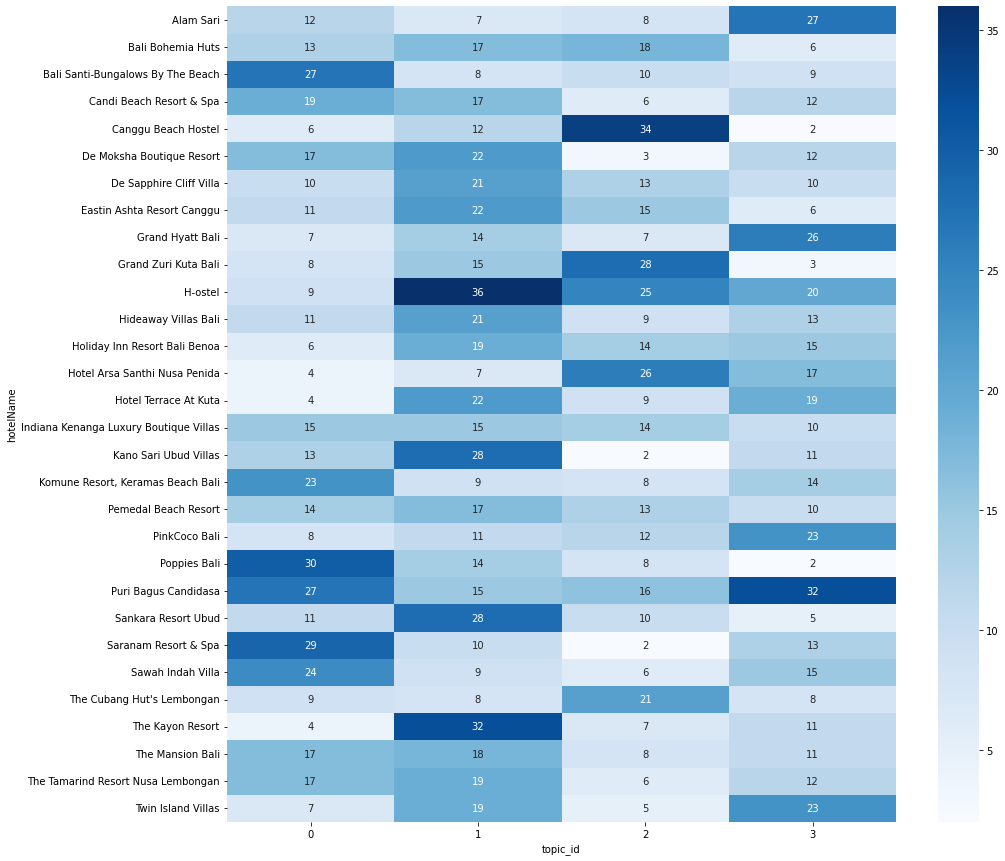

In [ ]:
df_cluster = df_raw.copy(deep=True)
df_listings = pd.read_csv(bali_hotel_list, on_bad_lines='skip') #creating new dataframe
# print(df_cluster.columns)
# print(df_listings.columns)
df_listings = df_listings.rename(columns={'Unnamed: 0': 'index'}) #renaming the column name to index
df_listings = df_listings.drop(['url', 'locality', 'tripadvisor_rating', 'checkIn', 'checkOut', 'price_per_night','booking_provider', 'no_of_deals', 'hotel_features'], axis=1) #drop columns that are not necessary for the analysis
hotel_dict = dict(zip(df_listings.index, df_listings.hotel_name))

df_cluster['corpus_tfidf'] = corpus_tfidf #created column in df_cluster which contains the TF-IDF scores for hotel review corpus
hotel_list = df_cluster['hotelName'].unique() #create a list of unique hotels
df_cluster['hotel_id'] = df_cluster['hotelName'].apply(lambda x: int((x.split())[0]))
df_cluster['hotelName'] = df_cluster['hotel_id'].apply(lambda x: hotel_dict[x]) #replace hotel name with corresponding value from hotel_dict
df_cluster['topic_id'] = df_cluster['corpus_tfidf'].apply(lambda x: sorted(lda_model_tfidf[x], key=lambda tup: -1*tup[1])[0][0]) #assigns the topic ID for each hotel review based on the highest-scoring topic from the corresponding TF-IDF scores
df_cluster.hotel_id = df_cluster.hotel_id.astype(int)

df_cluster_trim = df_cluster.drop(['index', 'review_body', 'corpus_tfidf', 'hotel_id'], axis=1) #drop certain columns that are not necessary
pivot_table = pd.pivot_table(df_cluster_trim, values='topic_id', index='hotelName', columns='topic_id', aggfunc=len, fill_value=0) #creates a pivot table  that shows the frequency of each topic ID for each hotel name in df_cluster_trim.
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(pivot_table, annot=True, cmap='Blues', ax=ax) #the pivot table is shown as a heatmap
for idx, topic in lda_model_tfidf.print_topics(-1):
  strings = [t.split('"')[1] for t in topic.split('+')]
  result = ', '.join(strings)
  print('Topic: {}: {}'.format(idx, result))

*  Applied the trained LDA model to the TF-IDF corpus and selects the topic with the highest probability for each document.
*  We are grouping the df_cluster_trim dataframe by hotelName and topic_id and counts the number of reviews in each group.
*  Created a pivot table that shows the number of reviews for each hotel and topic.
* We already created four topics using LDA
* The heatmap shows the number of reviews for each hotel and topic

For example :
*   Canguu Beach Hostel has 6 reviews related to 'topic 0' , 12 reviews related to 'topic 1', 34 reviews related to 'topic 2' and 2 reviews related to 'topic 3'
*   The Manison Bali has 17 reviews related to 'topic 0' , 18 reviews related to 'topic 1',8 reviews related to 'topic 2' and 11 reviews related to 'topic 3'







##Get Number of Each Topic and Map Hotels to their Max Count topic

In [ ]:
grouped_df = df_cluster.groupby(['hotelName', 'topic_id']).size().reset_index(name='count') #group by 'hotelName', 'topic_id', and size of each group
idx = grouped_df.groupby('hotelName')['count'].idxmax() #finds the index of the maximum value of the count column
max_topic_ids = grouped_df.loc[idx][['hotelName', 'topic_id']] #selects the rows of the grouped_df DataFrame that correspond to the maximum count for each hotel, using the index labels in idx
max_topic_ids.columns = ['hotelName', 'max_topic_id']
print(max_topic_ids.groupby(['max_topic_id']).size())
grouped = max_topic_ids.groupby('max_topic_id')['hotelName'].agg(list) #grouped object is a dictionary that maps each max_topic_id to a list of hotels that belong to that topic
topic_hotel_dict = {idx: names for idx, names in grouped.items()} #maps each max_topic_id to a list of hotels that belong to that topic
pprint(topic_hotel_dict)

max_topic_id
0     7
1    13
2     5
3     5
dtype: int64
{0: ['Bali Santi-Bungalows By The Beach',
     'Candi Beach Resort & Spa',
     'Indiana Kenanga Luxury Boutique Villas',
     'Komune Resort, Keramas Beach Bali',
     'Poppies Bali',
     'Saranam Resort & Spa',
     'Sawah Indah Villa'],
 1: ['De Moksha Boutique Resort',
     'De Sapphire Cliff Villa',
     'Eastin Ashta Resort Canggu',
     'H-ostel',
     'Hideaway Villas Bali',
     'Holiday Inn Resort Bali Benoa',
     'Hotel Terrace At Kuta',
     'Kano Sari Ubud Villas',
     'Pemedal Beach Resort',
     'Sankara Resort Ubud',
     'The Kayon Resort',
     'The Mansion Bali',
     'The Tamarind Resort Nusa Lembongan'],
 2: ['Bali Bohemia Huts',
     'Canggu Beach Hostel',
     'Grand Zuri Kuta Bali',
     'Hotel Arsa Santhi Nusa Penida',
     "The Cubang Hut's Lembongan"],
 3: ['Alam Sari',
     'Grand Hyatt Bali',
     'PinkCoco Bali',
     'Puri Bagus Candidasa',
     'Twin Island Villas']}


##Understanding the topics and showing what hotels belong to each topics

###Topic: 0: hotel, love, beauti, resort, view, great, stay, room, night, villa

--This topics refers to hotels and resorts with great views and villas

**These hotels include:** ['Bali Santi-Bungalows By The Beach',
     'Candi Beach Resort & Spa',
     'Indiana Kenanga Luxury Boutique Villas',
     'Komune Resort, Keramas Beach Bali',
     'Poppies Bali',
     'Saranam Resort & Spa',
     'Sawah Indah Villa']

###Topic: 1: good, hotel, villa, room, nice, breakfast, place, great, clean, love

--This topic refers to hotels that are relatively clean and serve breakfast

**These hotels include:** ['De Moksha Boutique Resort',
     'De Sapphire Cliff Villa',
     'Eastin Ashta Resort Canggu',
     'H-ostel',
     'Hideaway Villas Bali',
     'Holiday Inn Resort Bali Benoa',
     'Hotel Terrace At Kuta',
     'Kano Sari Ubud Villas',
     'Pemedal Beach Resort',
     'Sankara Resort Ubud',
     'The Kayon Resort',
     'The Mansion Bali',
     'The Tamarind Resort Nusa Lembongan']

###Topic: 2: good, nice, hotel, beach, help, great, place, hostel, clean, room

--This topic refers to hotels and hostels that are clean and close to the beach

**These hotels include:** ['Bali Bohemia Huts',
     'Canggu Beach Hostel',
     'Grand Zuri Kuta Bali',
     'Hotel Arsa Santhi Nusa Penida',
     "The Cubang Hut's Lembongan"]

###Topic: 3: hotel, resort, servic, great, room, beach, beauti, stay, restaur, love

--This topic refers to hotels and resorts that have great service and possibly have a resturant

**These hotels include:** ['Alam Sari',
     'Grand Hyatt Bali',
     'PinkCoco Bali',
     'Puri Bagus Candidasa',
     'Twin Island Villas']


#Run SentenceTransformer and FAISS to implement Query-based Search

##Use the SentenceTransformer with 'paraphrase-mpnet-base-v2' and encode it

*   We are generating the embeddings for the reviews in the df_cluster DataFrame.
*  'paraphrase-mpnet-base-v2' model is a pre-trained transformer model that is designed to generate high-quality embeddings for natural language text.
*   encode() method returns a matrix of shape (num_sentences, embedding_size), where each row represents the embedding for a single sentence.

In [ ]:
sentences = df_cluster['review_body'].tolist() #converts 'review_body' into a list of sentences.
model = SentenceTransformer('paraphrase-mpnet-base-v2') # instantiates a pre-trained sentence embedding model
sentence_embeddings = model.encode(sentences) #encode the list of sentences into dense vector representations.

##Use the FAISS Index Flat IP and Generate results for query

*   Faiss library is used to build an index of sentence embeddings computed above
*   The index is then used to perform approximate nearest neighbor search given a query string.
*   The search function returns the 30 most similar reviews to the query, along with the corresponding hotel name and similarity score

In [ ]:
hotel_names = df_cluster['hotelName'].tolist()
d = sentence_embeddings.shape[1]
index = faiss.IndexFlatIP(d) #creates a new index for performing nearest neighbor searches using the IndexFlatIP class
index.add(sentence_embeddings) #adds the pre-computed sentence embeddings to the index
faiss.write_index(index, 'index_hotel_reviews')
index = faiss.read_index('index_hotel_reviews')

def search(query, k):
    query_vector = model.encode([query]) #encode the query string into a dense vector representation
    D,I = index.search(query_vector, k) #uses the index to perform a nearest neighbor search on the query vector and returns the k nearest neighbors
    reviews=[sentences[_id] for _id in I.tolist()[0]]
    hotel=[hotel_names[name] for name in I.tolist()[0]] #extracts the corresponding hotel names for the k nearest neighbors using the indices returned by the nearest neighbor search.
    scores=D.T.tolist() #extracts the similarity scores between the query vector and the k nearest neighbors
    for i in range(len(scores)):
      scores[i] = scores[i][0]
    ret_df=pd.DataFrame({'hotel':hotel,'score':scores,'reviews':reviews}) #this dataframe contains the hotel names, similarity scores, and reviews for the k nearest neighbors.
    return ret_df

faiss_query = "I want to stay in a hostel and maybe go surfing if possible"
results = search(faiss_query, 30)
results.loc[:5]

,hotel,score,reviews
0,Canggu Beach Hostel,8.461720,I really can recommend this hostel for all tho...
1,Canggu Beach Hostel,8.076028,This is a good hostel for meeting other travel...
2,Canggu Beach Hostel,7.972932,Great place to meet people if you're a solo tr...
3,Canggu Beach Hostel,7.783470,A fantastic hostel with a great social scene. ...
4,Canggu Beach Hostel,7.435611,"I would recommend this hostel, its near to the..."
5,Canggu Beach Hostel,7.431964,Lovely place with cool little bungalow type do...


##Show the top hotels based on the review search query

In [ ]:
faiss_recommendations = results['hotel'].unique() #contains a list of unique hotel names from the search results.
for i in range(len(faiss_recommendations)):
  print('FAISS Recommendation '+str(i+1)+': '+faiss_recommendations[i])

FAISS Recommendation 1: Canggu Beach Hostel
FAISS Recommendation 2: Hotel Terrace At Kuta
FAISS Recommendation 3: H-ostel
FAISS Recommendation 4: Eastin Ashta Resort Canggu


#Learnings and Reflection

From the dataset, we were able to look at various reviews and understand what kind of reviews are left for a hotel for both positive and negative contexts.  We learnt how to preprocess the reviews to ensure that all forms of a given word in a sentence were standardized to a base form of the word. Majority of our reviews had a positive connotation and through the TFIDF LDA model we were able to generate topic modeling "clusters" to categorize the reviews from the customers. We determined the optimal number of topics to be around 4 and we kept the number of passes to 2 to prevent some overfitting we encountered. We included the eta and alpha hyperparameters to make sure that the reviews were more evenly spread across the topics generated. One major problem we encountered was that the LDA model is nondeterministic so we had to run it various times to end up with topics that were significantly applicable and spread out in overall distribution. We were then able to group the hotels based on the topic most of their reviews were in and we talked about how these topics related to the environment and conditions of the hotel. LDA was fine for topic modeling but something like Non-negative Matrix Factorization (NMF) could also be tried out for topic modeling in the future. For the SentenceTransformer we used the 'paraphrase-mpnet-base-v2' model as it is trained through "Paraphrase Adversarial Training". This model is specifically trained on paraphrase identification, and as such, it is expected to produce high-quality sentence embeddings that capture the semantic meaning of sentences well. The FAISS IndexFlatIP is a type of FAISS index that uses inner product (IP) similarity search to find nearest neighbors. We found the combination of these two to net the best query results in the end. For the query “I want to stay in a hostel and maybe go surfing if possible", the top 3-5 similar review results all mentioned a hostel and surfing. We get the 30 most similar reviews and recommend the hotels listed in order of similarity score (30 can be changed via the k in the search function). In most cases if the query is specific enough, the first hotel will dominate the search. Overall, we learned some very important basic NLP techniques like topic modeling through LDA and we were able to create a string-based similarity search via sentence transformers and FAISS.